In [1]:
import collections
import datasets
import numpy as np
import torch
import transformers
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

/Users/ayush/Desktop/MINI PROJECT/pytorch-sentiment-analysis-main/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True


In [3]:
train_data, test_data = datasets.load_dataset("imdb", split=["train", "test"])

In [4]:
transformer_name = "bert-base-uncased"
tokenizer = transformers.AutoTokenizer.from_pretrained(transformer_name)


In [5]:
def tokenize_and_numericalize_example(example, tokenizer):
    ids = tokenizer(example["text"], truncation=True, padding='max_length', max_length=256)["input_ids"]
    return {"ids": ids}

train_data = train_data.map(
    tokenize_and_numericalize_example, fn_kwargs={"tokenizer": tokenizer}
)
test_data = test_data.map(
    tokenize_and_numericalize_example, fn_kwargs={"tokenizer": tokenizer}
)


Map: 100%|██████████| 25000/25000 [00:15<00:00, 1583.54 examples/s]


In [6]:
pad_index = tokenizer.pad_token_id

In [7]:
test_size = 0.25
train_valid_data = train_data.train_test_split(test_size=test_size)
train_data = train_valid_data["train"]
valid_data = train_valid_data["test"]

In [8]:
train_data.set_format(type="torch", columns=["ids", "label"])
valid_data.set_format(type="torch", columns=["ids", "label"])
test_data.set_format(type="torch", columns=["ids", "label"])


In [9]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [torch.tensor(i["ids"]) for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_label = torch.tensor([i["label"] for i in batch])
        batch = {"ids": batch_ids, "label": batch_label}
        return batch

    return collate_fn

In [10]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader


In [11]:
batch_size = 8
train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)


In [12]:
class Transformer(nn.Module):
    def __init__(self, transformer, output_dim, freeze):
        super().__init__()
        self.transformer = transformer
        hidden_dim = transformer.config.hidden_size
        self.fc = nn.Linear(hidden_dim, output_dim)
        if freeze:
            for param in self.transformer.parameters():
                param.requires_grad = False

    def forward(self, ids):
        output = self.transformer(ids, output_attentions=True)
        hidden = output.last_hidden_state
        cls_hidden = hidden[:, 0, :]
        prediction = self.fc(torch.tanh(cls_hidden))
        return prediction


In [13]:
transformer = transformers.AutoModel.from_pretrained(transformer_name)
output_dim = len(train_data["label"].unique())
freeze = False
model = Transformer(transformer, output_dim, freeze)


In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The model has {count_parameters(model):,} trainable parameters")


The model has 109,483,778 trainable parameters


In [15]:
lr = 1e-5
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = criterion.to(device)


In [17]:
def train(data_loader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm(data_loader, desc="training..."):
        ids = batch["ids"].to(device)
        label = batch["label"].to(device)
        prediction = model(ids)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)


In [18]:
def evaluate(data_loader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            label = batch["label"].to(device)
            prediction = model(ids)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)


In [19]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy


In [20]:
n_epochs = 3
best_valid_loss = float("inf")
metrics = collections.defaultdict(list)


In [22]:
for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, model, criterion, optimizer, device
    )
    valid_loss, valid_acc = evaluate(valid_data_loader, model, criterion, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "transformer.pt")
    print(f"Epoch: {epoch+1}/{n_epochs}")
    print(f"Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.3f}")
    print(f"Valid Loss: {valid_loss:.3f}, Valid Acc: {valid_acc:.3f}")


training...:   0%|          | 0/2344 [00:00<?, ?it/s]/var/folders/fp/q0m5t1y91ds296s1c7f_6w1c0000gn/T/ipykernel_14599/2839162243.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_ids = [torch.tensor(i["ids"]) for i in batch]
training...:   0%|          | 0/2344 [00:00<?, ?it/s]


KeyboardInterrupt: 

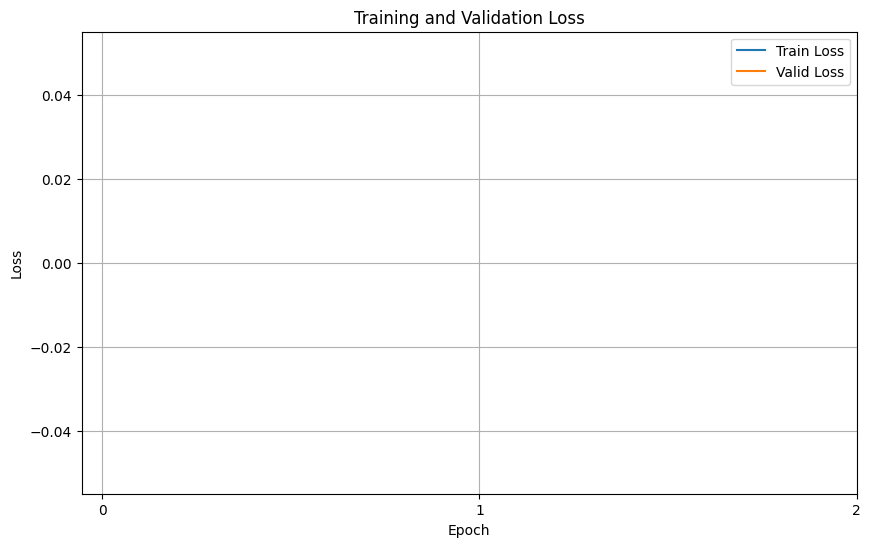

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(metrics["train_losses"], label="Train Loss")
plt.plot(metrics["valid_losses"], label="Valid Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(range(n_epochs))
plt.legend()
plt.grid()
plt.title("Training and Validation Loss")
plt.show()


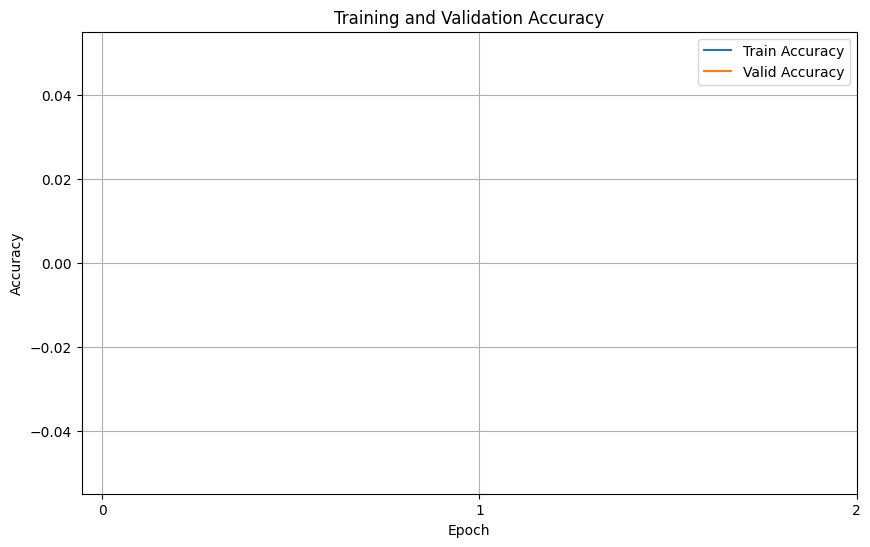

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(metrics["train_accs"], label="Train Accuracy")
plt.plot(metrics["valid_accs"], label="Valid Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks(range(n_epochs))
plt.legend()
plt.grid()
plt.title("Training and Validation Accuracy")
plt.show()


In [25]:
model.load_state_dict(torch.load("transformer.pt"))
test_loss, test_acc = evaluate(test_data_loader, model, criterion, device)
print(f"Test Loss: {test_loss:.3f}, Test Acc: {test_acc:.3f}")


FileNotFoundError: [Errno 2] No such file or directory: 'transformer.pt'

In [26]:
def predict_sentiment(text, model, tokenizer, device):
    ids = tokenizer(text, truncation=True, padding='max_length', max_length=256)["input_ids"]
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability


In [27]:
texts = [
    "This film is terrible!",
    "This film is great!",
    "This film is not terrible, it's great!",
    "This film is not great, it's terrible!"
]

In [28]:
for text in texts:
    print(f"Text: {text}")
    print(predict_sentiment(text, model, tokenizer, device))

Text: This film is terrible!
(0, 0.5899120569229126)
Text: This film is great!
(0, 0.5631393194198608)
Text: This film is not terrible, it's great!
(0, 0.5472971200942993)
Text: This film is not great, it's terrible!
(0, 0.6167016625404358)
